# BERT for sentiment analysis

In [ ]:
!pip install transformers
!pip install torchdata==0.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 14.7 MB/s 
     |████████████████████████████████| 7.6 MB 51.9 MB/s 
     |████████████████████████████████| 182 kB 72.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 13.2 MB/s 
     |████████████████████████████████| 140 kB 56.6 MB/s 
     |████████████████████████████████| 127 kB 62.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import torch

# if present, use the gpu as a device

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


## **Data Extraction and Cleaning**

In [ ]:
from bs4 import BeautifulSoup
import re

# Function to clean data

def clean_text(text,lemmatize = False):
    soup = BeautifulSoup(text, "html.parser") # Remove html tags
    text = soup.get_text()

    # Expanding chatwords and contracts clearing contractions
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji_clean.sub(r'',text)
    text = re.sub(r'\.(?=\S)', '. ',text)   # Add space after full stop
    text = re.sub(r'http\S+', '', text)     # Remove urls
    
    # Return token
    return text

In [ ]:
#Collect the dataset and clean the text
from torchtext.datasets import IMDB
import pandas as pd
from tqdm import tqdm

#Collect and join train set and test set
train_iter = IMDB(split='train')

sentences = []
labels = []

for label, line in train_iter:
    sentences.append(line)
    labels.append(label)


test_iter = IMDB(split='test')

for label, line in test_iter:
    sentences.append(line)
    labels.append(label)

#Map pos and neg in 1 and 0
df = pd.DataFrame({"text": sentences, "label": [1 if each == "pos" else 0 for each in labels]})

#Drop duplicates
df.drop_duplicates(inplace=True)

#Clean the data
df['text'] = df['text'].apply(clean_text)

#Select just a section of our data. This is just for didactic use, it helps to fasten the training. You can try to achieve better performances using the whole dataset
df = df.sample(frac=0.25)

#Assign the fields of the dataset to a variable 
text = df.text.values
labels = df.label.values

#Show the dataset
df

,text,label
4993,I am a Christian and I say this movie had terr...,0
8477,"Highly implausible, unbelievable, and incohere...",0
11552,"Though not a fan of Sam Rockwell, I was surpri...",0
31442,I bought this 'film' from a gas station in the...,0
5254,It looks like the brilliant team of Shonda Rhi...,0
...,...,...
7993,What this movie does well is combine action an...,0
3016,"Another FRIDAY THE 13TH ripoff, even featuring...",0
31039,"For any wrestling fan, this is the wrestlemani...",0
19006,"""Men of honor"" - true story about a proud and ...",1


## **Tokenizer and Data preparation**

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data, max_len):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text = sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=max_len,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
frase= "This movie is awesome"
tokenizer(frase, max_length=8, padding='max_length')

{'input_ids': [101, 2023, 3185, 2003, 12476, 102, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 0, 0]}

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data in train, validation and test set

X = text
y = labels


X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.1, random_state=2022)

X_train, X_val, y_train, y_val =\
    train_test_split(X_train, y_train, test_size=0.1, random_state=2023)

In [ ]:
#Study the average length of a text record
tot=0
for x in X:
  tot+=len(x.split())
print(tot/len(X))

228.45546950629236


In [ ]:
# Specify `MAX_LEN`
max_len = 230

# Run function `preprocessing_for_bert` on the train set, the validation set and the test set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train, max_len)
val_inputs, val_masks = preprocessing_for_bert(X_val, max_len)
test_inputs, test_masks = preprocessing_for_bert(X_test, max_len)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
test_labels = torch.tensor(y_test)

# For fine-tuning BERT, it's recommended a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=1)

## **Model Definition and Training**

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        
        D_in, H, D_out = 768, 100, 2 #The hidden level can be changed to improve the performances!

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.2), #Try to change the dropout value to improve the performances
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits


CPU times: user 31.8 ms, sys: 1 ms, total: 32.8 ms
Wall time: 36.4 ms


In [ ]:
import random
import time
import numpy as np

#Training procedure

# Specify loss function

#loss_fn=nn.BCELoss()
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()


def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False, accumulation=16):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")

    #list to be returned
    train_losses=[]
    train_accs=[]
    val_losses=[]
    val_accs=[]

    #For the first step of evaluation
    eval_loss=10000
    best_model=None

    for epoch_i in range(epochs):
        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        acc = 0
        total = 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(tqdm(train_dataloader)):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)


            with torch.cuda.amp.autocast():
                  model.zero_grad()
                  # Perform a forward pass. This will return logits.
                  logits = model(b_input_ids, b_attn_mask)
                  # Compute loss and accumulate the loss values
                  loss = loss_fn(logits, b_labels)
                  loss /= accumulation

            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            scaler.scale(loss).backward()

            # Accumulation step. It's fondamental when you try to train BERT on Colab GPUs, it avoids the error CUDA_OUT_OF_MEMORY 
            if (step + 1) % accumulation == 0 or step+1 == len(train_dataloader):
              scaler.step(optimizer)
              scaler.update()


        # Print training results
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9}")
        print("-"*70)

        # Reset batch tracking variables
        batch_loss, batch_counts = 0, 0

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        
        predictions = torch.max(logits, 1).indices.to(device)

        acc += (predictions.detach().cpu().numpy() == b_labels.detach().cpu().numpy()).sum()
        total += len(b_labels)

        epoch_acc = acc*100/total
        train_accs.append(epoch_acc)
        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.

            val_loss, val_accuracy = evaluate(model, val_dataloader)
            val_losses.append(val_loss)
            val_accs.append(val_accuracy)
            if val_loss <= eval_loss:
              eval_loss = val_loss
              best_model=model

            # Print performance over the entire training data            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f}")
            print("-"*70)
        print("\n")

    
    print("Training complete!")
    return train_losses, train_accs, val_losses, val_accs, best_model


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model():
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=True) 
    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = torch.optim.AdamW(bert_classifier.parameters(), 
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      ) #Try to change to improve the performances!


    return bert_classifier, optimizer

In [ ]:
set_seed(42)    # Set seed for reproducibility
epochs=4
bert_classifier, optimizer = initialize_model()
train_losses, train_accs, val_losses, val_accs, best_model = train(bert_classifier, train_dataloader, val_dataloader, epochs, evaluation=True)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...



100%|██████████| 628/628 [00:49<00:00, 12.76it/s]


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc 
----------------------------------------------------------------------
----------------------------------------------------------------------
   1    |    -    |   0.042585   |  0.668739  |   67.32  
----------------------------------------------------------------------




100%|██████████| 628/628 [00:49<00:00, 12.77it/s]


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc 
----------------------------------------------------------------------
----------------------------------------------------------------------
   2    |    -    |   0.041763   |  0.650994  |   67.11  
----------------------------------------------------------------------




100%|██████████| 628/628 [00:49<00:00, 12.66it/s]


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc 
----------------------------------------------------------------------
----------------------------------------------------------------------
   3    |    -    |   0.040864   |  0.637823  |   67.17  
----------------------------------------------------------------------




100%|██████████| 628/628 [00:49<00:00, 12.77it/s]


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc 
----------------------------------------------------------------------
----------------------------------------------------------------------
   4    |    -    |   0.039539   |  0.610744  |   77.11  
----------------------------------------------------------------------


Training complete!


##**Test procedure**

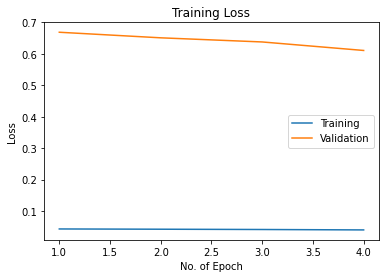

In [ ]:
import matplotlib.pyplot as plt


plt.plot(range(1, epochs+1), train_losses, label="Training")
plt.plot(range(1, epochs+1), val_losses, label="Validation")
plt.xlabel("No. of Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend(loc="center right")
plt.show()

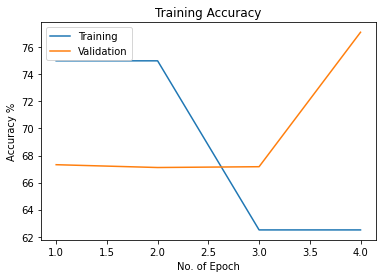

In [ ]:
plt.plot(range(1, epochs+1), train_accs, label="Training")
plt.plot(range(1, epochs+1), val_accs, label="Validation")
plt.xlabel("No. of Epoch")
plt.ylabel("Accuracy %")
plt.title("Training Accuracy")
plt.legend(loc="upper left")
plt.show()

In [ ]:
def predict(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()
    predictions=[]
    # Tracking variables
    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()
        predictions.append(int(preds.detach().cpu().numpy()))

    return predictions

In [ ]:
from sklearn.metrics import classification_report

bert_classifier.to(device)

predictions = predict(bert_classifier, test_dataloader)


print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.77      0.76      0.77       625
           1       0.76      0.76      0.76       615

    accuracy                           0.76      1240
   macro avg       0.76      0.76      0.76      1240
weighted avg       0.76      0.76      0.76      1240



In [ ]:
best_model.to(device)

predictions = predict(best_model, test_dataloader)


print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.77      0.76      0.77       625
           1       0.76      0.76      0.76       615

    accuracy                           0.76      1240
   macro avg       0.76      0.76      0.76      1240
weighted avg       0.76      0.76      0.76      1240

